### Imports

In [ ]:
# Imports
import torch as pt
from torch import nn

print(f"Torch version: {pt.__version__}")

# if pt.cuda.is_available():
#     device = 'cuda'
# if pt.backends.mps.is_available():
#     device = 'mps'
# else:
#     device= 'cpu'
device = 'cpu'
print(f'device: {device}')

Torch version: 2.0.1+cu118
device: cpu


### Downloading a custom dataset

In [ ]:
from pathlib import Path
import importLib
from sys import path
import zipfile


# Create directory
data_path = Path(f"{path[0]}/data")
image_path = data_path / 'pizza_steak_sushi'
if image_path.exists():
    print('Already exists')
else:
    image_path.mkdir(parents=True)


# Download pizza, steak and sushi data
# open skapar en zip fil som sedan fylls genom request
importLib.import_from_github('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip',directory=data_path)
with zipfile.ZipFile(data_path/'pizza_steak_sushi.zip', 'r') as zip_ref:
    print('Unzipping pizza, steak and sushi data')
    zip_ref.extractall(image_path)
Path.unlink(data_path/'pizza_steak_sushi.zip')


/content/data/pizza_steak_sushi.zip doesn't exist, download
Unzipping pizza, steak and sushi data


In [ ]:
# Setup training and testing paths
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('/content/data/pizza_steak_sushi/train'),
 PosixPath('/content/data/pizza_steak_sushi/test'))

### Create dataset and dataloaders

In [ ]:
from torchvision import transforms
simple_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets

train_dataset = datasets.ImageFolder(root = train_dir, transform=simple_transform)
test_dataset = datasets.ImageFolder(root = test_dir, transform=simple_transform)

In [ ]:
import os
BATCH_SIZE = 32
NUM_WORKERS = round(os.cpu_count()*(3/4))
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=32,
    num_workers=NUM_WORKERS,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=32,
    num_workers=NUM_WORKERS,
    shuffle=False
)

### Create a model without Augmention

In [ ]:
from torch import nn

class TinyVGG(nn.Module):
    def __init__(self, input_features:int,output_features:int, hidden_units:int=10):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(input_features, hidden_units,
                      kernel_size=3, stride=1, padding=0),
            nn.ReLU(),


            nn.Conv2d(hidden_units, hidden_units,
                      kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units,
                      kernel_size=3, stride=1, padding=0),
            nn.ReLU(),


            nn.Conv2d(hidden_units, hidden_units,
                      kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units*13*13, output_features)
        )
    def forward(self, X:pt.Tensor) -> pt.Tensor:
        X_change = self.conv_block_1(X)
        X_change = self.conv_block_2(X_change)
        # print(X_change.shape)
        X_change = self.classifier(X_change)
        return X_change

#### Testing model with random data

In [ ]:
pt.manual_seed(42)
model0 = TinyVGG(input_features=3, output_features=len(train_dataset.classes), hidden_units=10).to(device)
model0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [ ]:
imgs, labels = next(iter(train_dataloader))
print(imgs.shape, len(labels))
# model0(imgs[0].unsqueeze(0))
model0(imgs.to(device))

torch.Size([32, 3, 64, 64]) 32


tensor([[ 2.0795e-02, -1.9510e-03,  9.5213e-03],
        [ 1.8440e-02,  2.4669e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9127e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6416e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7905e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7981e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1815e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7457e-03,  8.4966e-03],
        [ 1.9974e-02, -3.4273e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6379e-03,  8.5491e-03],
        [ 2.0768e-02

### Summarize a model

In [ ]:
try:
    import torchinfo
except ModuleNotFoundError:
    print('Module not found, installing module')
    !pip3 install torchinfo
    import torchinfo

Module not found, installing module


In [ ]:
torchinfo.summary(model0, input_size=[32,3,64,64],device=device)

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 10, 62, 62]          280
│    └─ReLU: 2-2                         [32, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 10, 60, 60]          910
│    └─ReLU: 2-4                         [32, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 10, 30, 30]          --
├─Sequential: 1-2                        [32, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 10, 28, 28]          910
│    └─ReLU: 2-7                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 10, 26, 26]          910
│    └─ReLU: 2-9                         [32, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 10, 13, 13]          --
├─Sequentia

### Create train and test loop functions

In [ ]:
from torch.utils.data import DataLoader
def train_step(model: pt.nn.Module,
               dataloader:DataLoader,
               loss_fn: pt.nn.Module,
               optimizer:pt.optim.Optimizer,
               device:pt.device,
               show:bool=False):
    """Performs a training step with model trying to learn on data_loader

    args:
        model: the model which will be trained on
        dataloader: A generator like loader for the data
        optimizer: Optimizer which optimizes the code through gradient descend
        loss_fn: function which calculates how far from the right answer each of the predictions were
        accuracy_fn: function which calculates how meny predictions were right
        device: chosen device for the neural network to run on (cpu/gpu/tpu)
        show: if true display the loss and acc in console

    returns:
        (loss, accuracy)"""
    # Put model in training mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0,0

    # Loop through data loader batches
    for X,y in dataloader:
        # Send data to target device
        X,y = X.to(device), y.to(device)

        y_logits = model(X)

        loss = loss_fn(y_logits, y)
        train_loss+=loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_preds = pt.argmax(pt.softmax(y_logits, dim=1), dim=1) # Softmax is actually unnecessary, but can be useful for visualization and also to give completeness
        train_acc += (y_preds == y).sum().item()/len(y_preds)
    train_loss /= len(dataloader)
    train_acc  /= len(dataloader)

    if show:
        print(f'Train loss: {train_loss} | Train acc: {train_acc}')
    return train_loss, train_acc

In [ ]:
def test_step(model: pt.nn.Module,
              dataloader:DataLoader,
              loss_fn: pt.nn.Module,
              device:pt.device,
              show:bool=False):
    """Performs a testing loop step on model going over data_loader.

    args:
        model: the model which will be trained on
        dataloader: A generator like loader for the data
        loss_fn: function which calculates how far from the right answer each of the predictions were
        accuracy_fn: function which calculates how meny predictions were right
        device: chosen device for the neural network to run on (cpu/gpu/tpu)
        show: if true display the loss and acc in console

    returns:
        (loss, accuracy)"""
    test_acc, test_loss = 0,0

    model.eval()
    with pt.inference_mode():
        for X,y in dataloader:
            X,y = X.to(device), y.to(device)
            y_logits = model(X)
            loss = loss_fn(y_logits, y)
            test_loss+=loss.item()

            y_preds = pt.argmax(pt.softmax(y_logits, dim=1), dim=1)
            test_acc += (y_preds== y).sum().item()/len(y_preds)
    test_loss /= len(dataloader)
    test_acc  /= len(dataloader)

    print(f'Test loss: {test_loss} | Test acc: {test_acc}') if show else None
    return test_loss, test_acc

In [ ]:

from tqdm.notebook import tqdm
def train(epochs:int, model:pt.nn.Module, train_dataloader:DataLoader, test_dataloader:DataLoader, loss_fn, optimizer:pt.optim.Optimizer, device:pt.device,show:bool):
    """Trains the model"""
    # Create an empty dictionary to hold results in
    results = {
        "train_loss":[],
        "train_acc":[],
        "test_loss":[],
        "test_acc":[]
        }

    for epoch in tqdm(range(epochs)):
        print(f'Epoch: {epoch}') if show else None
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device,
            show=show)

        test_loss, test_acc = test_step(
            model=model,
            dataloader= test_dataloader,
            loss_fn= loss_fn,
            device= device,
            show=show
            )

        # Append our values to results
        results["train_loss"].append(train_loss); results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss); results["test_acc"].append(test_acc)
    return results

In [ ]:
pt.manual_seed(42)
pt.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(3, len(train_dataset.classes), 10).to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer = pt.optim.Adam(params=model_0.parameters(), lr=0.001)

from ml_funcs import Timer
timer = Timer()

# Train model_0
model_0_results = train(
    epochs=5,
    model=model_0,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=device,
    show=True)
timer.show_as_print()


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
Train loss: 1.1063190400600433 | Train acc: 0.3046875
Test loss: 1.0983218749364216 | Test acc: 0.30113636363636365
Epoch: 1
Train loss: 1.0997934490442276 | Train acc: 0.328125
Test loss: 1.0697215398152669 | Test acc: 0.5416666666666666
Epoch: 2
Train loss: 1.0869051963090897 | Train acc: 0.48828125
Test loss: 1.0808271169662476 | Test acc: 0.49242424242424243
Epoch: 3
Train loss: 1.0842876136302948 | Train acc: 0.3984375
Test loss: 1.0608015060424805 | Test acc: 0.5833333333333334
Epoch: 4
Train loss: 1.0662547051906586 | Train acc: 0.4140625
Test loss: 1.065469741821289 | Test acc: 0.5643939393939394

Timer: by GGisMee
Total time:
 11.87



### Save and load model + evaluate

In [ ]:
from sys import path
model_path = f'{path[0]}/models'
from ml_funcs import save_load, Model_operations

# save_load.save_state_dict(model_0, 'ModelWithoutAugmentation0', model_path)
try:
  loaded_model = save_load.load_state_dict(TinyVGG(3,len(train_dataset.classes), 10), 'ModelWithoutAugmentation0', model_path)
except FileNotFoundError:
  print('File not found')

File not found


In [ ]:
import matplotlib.pyplot as plt
def plot_loss_curves(results: dict[str, list[float]]):
    """Plots training curves of a results dictionary"""
    # Get the loss values of the results dictionary

    # train results
    train_loss = results['train_loss']
    train_acc = results['train_acc']

    # test results
    test_loss = results['test_loss']
    test_acc = results['test_acc']

    # epochs
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.subplot(1,2,1)
    plt.plot(epochs, train_loss, label='train loss', color='red')
    plt.plot(epochs, test_loss, label='test loss', color='green')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()


    plt.subplot(1,2,2)
    plt.plot(epochs, train_acc, label='train accuracy',color='orange')
    plt.plot(epochs, test_acc, label='train accuracy', color='blue')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()


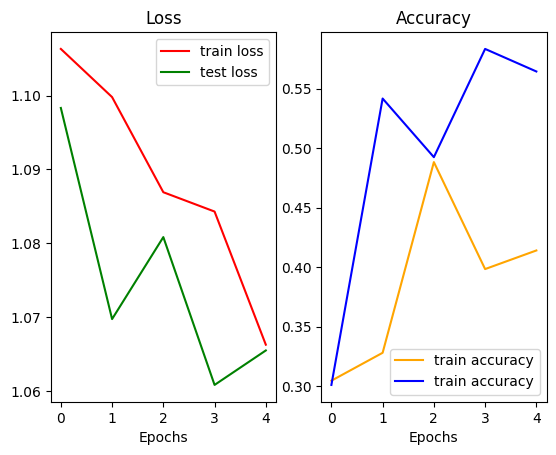

In [ ]:
plot_loss_curves(model_0_results)

### Augmented model

#### What does an ideal loss curve look line and how do you make your loss curve look ideal?

https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic

How to see if your model is overfitting or underfitting:

**Underfitting:**
* The models loss is high and reducing itself slowly

**Overfitting:**
* Train loss is alot higher than test loss


Now let's try another modelling experiment this time using the same model as before but with some data augmentation

In [ ]:
# Create training transform with TrivialAugment
from torchvision import transforms
train_transform_trivial = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # between 0-31 in transformation
    transforms.ToTensor()
])

test_transforms_simple = transforms.Compose([
    transforms.Resize((64,64))
])

#### Create train and test Dataset+DataLoaders with data augmentation

In [ ]:
from torchvision import datasets
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = round(os.cpu_count()*(3/4))
pt.manual_seed(42)

# Datasets
aug_train_data = datasets.ImageFolder(train_dir, train_transform_trivial)
aug_test_data = datasets.ImageFolder(test_dir, train_transform_trivial)

# DataLoaders
aug_train_dataloader = DataLoader(dataset=aug_train_data, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
aug_test_dataloader = DataLoader(dataset=aug_test_data, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

#### Create model 1 with data augmenatation, thus change the data, but not really the model

In [ ]:
#### Creat model 1 with data augmentation
pt.manual_seed(42)
model_1 = TinyVGG(3, len(aug_test_data.classes), 10)

#### Create the training loop using train() function

As we can see our results point out that data augmentation isn't really needed, because our model performs better without data augmentation

This can be seen on the loss curvature of model_0 which had a good negative mean gradient (pointed downwards quite much)

In [30]:
from torch import nn
import torch as pt
from helper_functions import set_seeds
from ml_funcs import Timer, Model_operations
set_seeds(42)
NUM_EPOCHS = 5

# Loss func
aug_loss_fn = nn.CrossEntropyLoss()

# Optimizer
aug_optimizer = pt.optim.Adam(params=model_1.parameters(), lr=0.001)

timer = Timer()

# Train model 1
model_1_results = Model_operations.train(
    epochs=NUM_EPOCHS,
    model=model_1,
    train_dataloader=aug_train_dataloader,
    test_dataloader=aug_test_dataloader,
    loss_fn=aug_loss_fn,
    optimizer=aug_optimizer,
    device=device,
    show=True)

timer.show_as_print()




  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
Train loss: 1.0835778787732124 | Train acc: 0.44140625
Test loss: 1.0937292575836182 | Test acc: 0.3229166666666667
Epoch: 1
Train loss: 1.0675554722547531 | Train acc: 0.43359375
Test loss: 1.1120017965634663 | Test acc: 0.2604166666666667
Epoch: 2
Train loss: 1.0221450626850128 | Train acc: 0.43359375
Test loss: 1.1202688018480937 | Test acc: 0.2916666666666667
Epoch: 3
Train loss: 1.0719737261533737 | Train acc: 0.3515625
Test loss: 1.1406211654345195 | Test acc: 0.23958333333333334
Epoch: 4
Train loss: 1.0328646078705788 | Train acc: 0.52734375
Test loss: 1.1506311098734539 | Test acc: 0.2604166666666667

Timer: by GGisMee
Total time:
 11.87



Loss going up indicates something is going bad, to get a better view try with more epochs

It looks as our model is both overfitting and underfitting as well, because of how the test_loss is quite a bit higher then our train loss and both are high values far from 0

In [31]:
plot_loss_curves(model_1_results)

TypeError: ignored

## 10. Compare model results
After evaluating our modelling expoeriments on their own, its time to compare them to each other

There are a few different ways to do this:
1. Hard code it yourself
2. Pytorch + Tensorboard: https://pytorch.org/docs/stable/tensorboard.html
3. Weights & Biases: https://wandb.ai/site/experiment-tracking
4. MlFlow: https://mlflow.org/


In [ ]:
# Import wandb or Weights and Biases
try:
    import wandb
except ModuleNotFoundError:
    print('Module not found, installing module')
    !pip3 install wandb
    import wandb

In [ ]:
'Log into the website'
wandb.login()

In [ ]:
# Create a run, which is like saying, we want our model to run and be displayed with these parameters
wandb.init(
    project='Training 04, Augmenatation and Custom datasets',
    config={
        'learning rate':0.001,
        'architecture': 'cnn',
        'dataset': 'Food101 subclass',
        'epochs':5,
    },
    name='with augmentation'
)

# This is a substitute for logging within the epoch loop as we don't want to change the train function, therefore we can instead deploy the results here right into the logging feature
model = model_1_results
for i,_ in enumerate(model['train_loss']):
  values_at_index = {key: values[i] for key, values in model.items()}
  wandb.log(values_at_index)

# Simply ends the run
wandb.finish()

### Making a prediction on a custom image
Although our model isn't perfect, we can still try predicting on it

Right now, we have used custom data, but  how do you make a prediction on a sample or image thats chosen by yourself

##### 1. Get a custom image

In [ ]:
from sys import path
import importLib
from pathlib import Path

# Download image
image_dir = path[0] + '/custom_data'
image_path = image_dir+'/04-pizza-dad.jpeg'

Path(image_dir).mkdir()

link = 'https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/04-pizza-dad.jpeg'
importLib.import_from_github(https=link, directory=image_dir)

#### 2. Loadign in a custom image with PyTorch
We have to make sure our custom image is in the same format as the model was trained open

* In Tensor form
* Of shape 64x64x3
* On the right device

We can read an image into PyTorch as a using: https://pytorch.org/vision/stable/generated/torchvision.io.read_image.html#torchvision.io.read_image

In [ ]:
import torchvision

# print(type(image_path))

# uint8 is a format of images
# IO stands for Input / Output
custom_image_uint8 = torchvision.io.read_image(image_path).to(device)

# currently in 0-255 as rgb max, model likes 0-1
custom_image_uint8 = custom_image_uint8/255

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(custom_image_uint8.permute(1,2,0))
plt.axis(False)
plt.title('custom image')

In [ ]:
print(r"As you can see here the image's shape is not 3x64x64 which the model wants")
print(f'Custom image: {custom_image_uint8.shape}')
try:
    print(f'Model image: {train_dataset[0][0].shape}')
except NameError as e:
    print(e)


### Making a prediction on a custom image with trained PyTorch model

In [ ]:
model = model_1
with pt.inference_mode():
    y_logits = model_1(custom_image_uint8)

NameError: name 'model_1' is not defined